In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_ranking as tfr
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, ConvLSTM1D, Flatten, LSTM, Permute, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Reshape, SpatialDropout1D, Dropout, TimeDistributed

from keras.regularizers import l2, l1


from sklearn.decomposition import PCA
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import f1_score
import sklearn

import pickle

from featurize import featurize

from scaler import CustomScaler
from VAE import get_auth_model, VAE

class SplitLayer(tf.keras.layers.Layer):
    def __init__(self, layers):
        super(SplitLayer, self).__init__()
        self.layers = layers

    def call(self, inputs):
        return tf.gather(inputs,indices=self.layers,axis=-1)


def get_discriminator(input_dim=(200,16)):
    #input_dim = (200,16)
    
    inputs = keras.Input(shape=input_dim)
    x = inputs
    
    xs = []
    
    for i in range(16):
        
        x = SplitLayer(i)(inputs)
        reshaped = Reshape((200, 1))(x)
        
        x = Conv1D(100, 10, strides=2, padding="same")(reshaped)   #, kernel_regularizer=l2(1e-5)
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)
        
        x = Conv1D(100, 3, strides=1,  padding="same")(x)     #   kernel_regularizer=l2(1e-5),
        x = MaxPooling1D(pool_size=2, strides=None, padding="same")(x)

        
        xs.append(x)
    
    x = layers.Concatenate()(xs)
    x = LSTM(50)(x)

    x = Dense(25, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(10, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation="sigmoid")(x)
    #x = layers.Lambda(lambda x: x / 2)
    out = x

    model = keras.Model(inputs, out, name="differentiating_fake_gestures")
    
    return model



2023-02-07 17:10:31.302361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 17:10:32.299043: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-07 17:10:32.299140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-07 17:10:32.299152: W tensorfl

In [2]:
file_name = "raw_with_maps" # or offsets_2

x_data = np.load(f"data/processed/x_{file_name}_filtered.npy") # pre-filtered data is "windowed_filtered"
feature_x_data = np.load(f"data/processed/x_{file_name}_features.npy")
y_user = np.load(f"data/processed/y_user_{file_name}.npy")
y_intent = np.load(f"data/processed/y_intent_{file_name}.npy")
y_gesture = np.load(f"data/processed/y_gesture_type_{file_name}.npy")

train_gesture_map = np.load(f"data/processed/train_gesture_map_{file_name}.npy")
test_gesture_map = np.load(f"data/processed/test_gesture_map_{file_name}.npy")

In [3]:
vae = VAE(None, None, None, None)
vae.load_model("all_users", "filtered_specifically_trained_v3_30")

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-02-07 13:44:36           64
config.json                                    2023-02-07 13:44:36        38011
variables.h5                                   2023-02-07 13:44:36      3551848
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......concatenate
.........vars
......conv1d
.........vars
............0
............1
......conv1d_1
.........vars
............0
............1
......conv1d_10
.........vars
............0
............1
......conv1d_11
.........vars
............0
............1
......conv1d_12
.........vars
............0
............1
......conv1d_13
.........vars
............0
............1
......conv1d_14
.........vars
............0
............1
......conv1d_15
.........vars
............0
............1
......conv1d_16
.........vars
............0
............1
......conv1d_17
.........

Model: "differentiating_fake_gestures"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 16)]    0           []                               
                                                                                                  
 split_layer (SplitLayer)       (None, 200)          0           ['input_1[0][0]']                
                                                                                                  
 split_layer_1 (SplitLayer)     (None, 200)          0           ['input_1[0][0]']                
                                                                                                  
 split_layer_2 (SplitLayer)     (None, 200)          0           ['input_1[0][0]']                
                                                                      

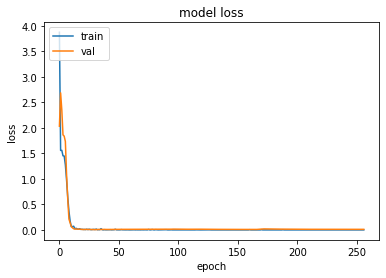

<Figure size 432x288 with 0 Axes>

In [8]:
data_train = x_data[train_gesture_map == 1]

reconstructed_data_train = vae.scaler.inverse_transform(vae.decoder(vae.encoder(vae.scaler.transform(data_train))[0]).numpy())

data_train = np.concatenate([data_train, reconstructed_data_train])

labels_train = np.concatenate([np.ones(len(data_train)//2), np.zeros(len(data_train)//2)])


shuffled_data_train, shuffled_labels_train = shuffle(data_train, labels_train, random_state=0)

scaler = CustomScaler()
shuffled_data_train = scaler.fit_and_transform(shuffled_data_train)


model = get_discriminator((200,16))
model.summary()

model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))



kFold = sklearn.model_selection.StratifiedKFold(n_splits=5)
val_map = next(kFold.split(shuffled_data_train, shuffled_labels_train))[1]


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=50,
                                                           patience=10, restore_best_weights=True)



history = model.fit(shuffled_data_train[~val_map], shuffled_labels_train[~val_map], epochs=1000,
                    batch_size=128, verbose=1,
                    validation_data=(shuffled_data_train[val_map], shuffled_labels_train[val_map]),
                   class_weight={0:0.5, 1:30},
                   callbacks=[early_stopping_callback])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.clf()



In [1]:
!pip install tensorflow_ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 64.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 3.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 40.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.8 MB/s eta 0:00:0000:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.1
    Uninstalling numpy-1.23.1: